Ước lượng Lipschitz theo y: 2
Ước lượng Lipschitz theo y_delay: 1
Độ biến thiên (gradient) delay: 0
(Nếu các giá trị này quá lớn, có thể báo hiệu vi phạm giả định Lipschitz.)



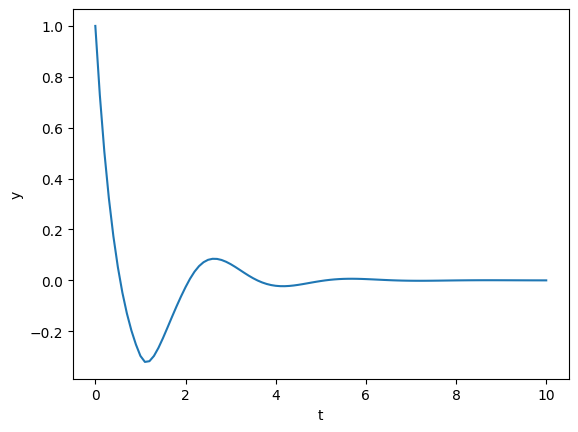

(101, 101)

In [19]:
from doan1_dongian.lib_RK_MoS import *
import numpy as np
import matplotlib.pyplot as plt
 
def f(t, y, y_delay):
    return -y_delay -2*y
def tau(t, y):
    return 1.0
def phi(t):
    return 1
t0 = 0
tf = 10.0
h0 = 0.1
tol = 1e-6
check_conditions(f, tau, phi, t0)

sol01 = solve_dde(
    f=f,
    tau=tau,
    phi=phi,
    t0=t0,
    t_final=tf,
    tol=1e-6,      # sai số có thể giảm xuống 1e-7, 1e-8 nếu cần
    h_init=0.1,    # bước khởi tạo
    h_min=1e-10,   # bước nhỏ nhất
    h_max=0.5,      # bước lớn nhất
    adaptive=False
)
# sol005 = solve_dde(
#     f=f,
#     tau=tau,
#     phi=phi,
#     t0=t0,
#     t_final=tf,
#     tol=1e-6,      # sai số có thể giảm xuống 1e-7, 1e-8 nếu cần
#     h_init=0.05,    # bước khởi tạo
#     h_min=1e-10,   # bước nhỏ nhất
#     h_max=0.5,      # bước lớn nhất
#     adaptive=False
# )
t_values_01 = [node['t'] for node in sol01]
y_values_01 = [node['y'] for node in sol01]
# t_values_005 = [node['t'] for node in sol005]
# y_values_005 = [node['y'] for node in sol005]
plt.plot(t_values_01, y_values_01)
plt.xlabel('t')
plt.ylabel('y')
plt.show()
len(t_values_01), len(y_values_01)


/Users/bao/Documents/đồ án 1/code/Numerical_method_for_DDE/doan1_dongian/lib_collocation.py:167: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  K_flat = fsolve(F, K0.flatten())


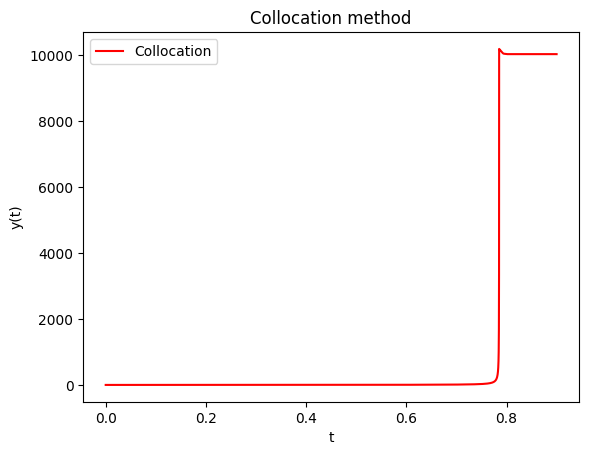

In [9]:
from doan1_dongian.lib_collocation import *
import numpy as np
import matplotlib.pyplot as plt
# hàm np.atleast_1d sẽ trả về một mảng có ít nhất 1 chiều
def f(t, y, y_delay):
    y = np.atleast_1d(y)
    y_delay = np.atleast_1d(y_delay)
    return y**2+y_delay**2
def tau(t, y):
    return 1.0
def phi(t):
    return np.atleast_1d(1.0)

t0 = 0
tf = 0.9
h0 = 1e-4
tol = 1e-6
# sau này sẽ thêm các hàm ước lượng Lipchitz sau
L_f_u = 0.0
L_f_v = 1.0
L_tau_y = 0.0

ts, ys = solve_dde_collocation(f, tau, phi, t0, tf, h0,
                                              method_name='gauss', s=2, tol=tol,
                                              L_f_u=L_f_u, L_f_v=L_f_v, L_tau_y=L_tau_y,
                                              h_min=1e-6, h_max=0.1, adaptive=False)
plt.plot(ts, ys, 'r-', label='Collocation')
plt.title('Collocation method')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
def compute_error(ts, ys):
    return np.abs(ys[:, 0] - y_exact(ts))
def plot_error(ts, errors):
        plt.figure(figsize=(10, 6))
        plt.plot(ts, errors, 'r-', label='Sai số')
        plt.xlabel('t')
        plt.ylabel('Sai số')
        plt.yscale('log')
        plt.title("Sai số giữa nghiệm chính xác và nghiệm nội suy")
        plt.legend()
        plt.show()
# errors = compute_error(ts, ys)
# plot_error(ts, errors)



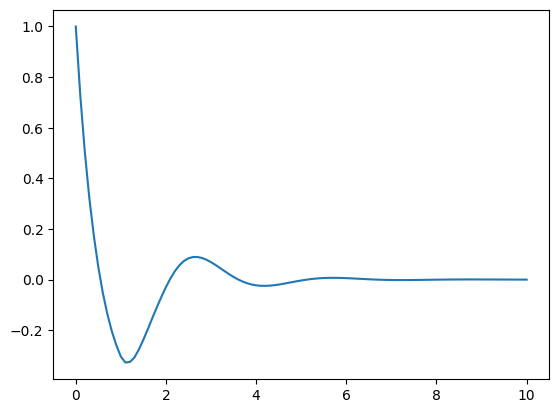

In [1]:
from multistep import *
import numpy as np
import matplotlib.pyplot as plt
def f(t, y, y_delay):
    return -2*y - y_delay
tau = 1.0
def phi(t):
    return 1.0
t0, tf, h = 0.0, 10, 0.1
t_grid, y_grid = epmm24(f, phi, t0, tf, tau, h)
plt.plot(t_grid, y_grid, label="EPMM(2,4)")


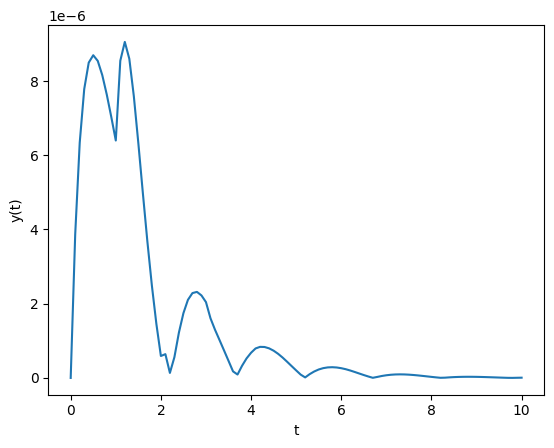

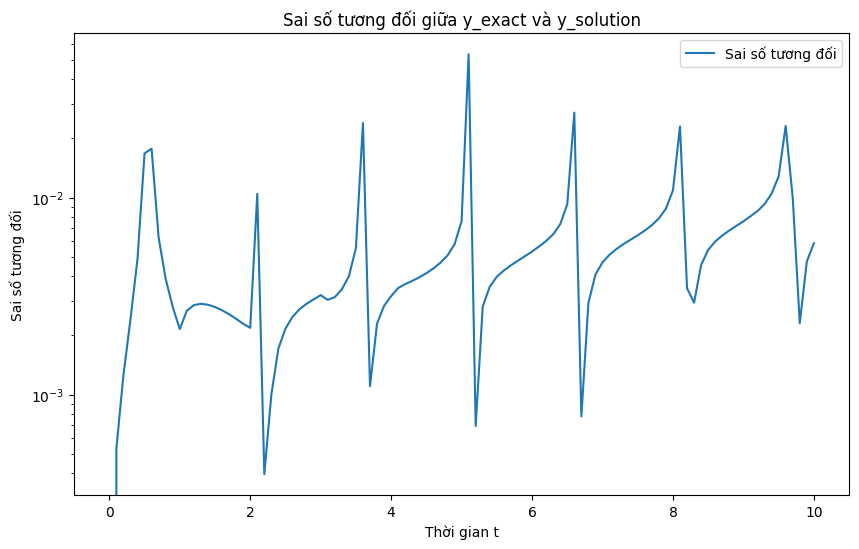

In [20]:
#đọc file y_exact.txt, trong file này có 1 cột là cột y
y_exact = np.loadtxt('y_exact01.txt')
errors = np.abs(y_values_01 - y_exact)
plt.plot(ts, errors, label="Sai số")
plt.xlabel('t')
plt.ylabel('y(t)')

#tính sai số tương đối
relative_error = np.abs((y_exact - y_values_01) / y_exact)*100
plt.figure(figsize=(10, 6))
plt.plot(ts, relative_error, linestyle='-', label='Sai số tương đối')
plt.xlabel('Thời gian t')
plt.yscale('log')
plt.ylabel('Sai số tương đối')
plt.title('Sai số tương đối giữa y_exact và y_solution')
plt.legend()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Dùng pandas.read_csv để đọc file, bỏ qua các dòng bắt đầu bằng '#'.
df = pd.read_csv("logistic_dde_solution.txt", comment='#', sep='\s+', header=None)
# Giả sử cột 0 là t và cột 1 là y:
y_exact = df[1].values[:]
print(y_exact)
# Tạo một mảng t từ 0 đến 100 với bước nhảy 0.1
stop = 100
start = 0
step = 0.1
t = np.arange(0, stop+step, step)
#vẽ đồ thị
plt.plot(t, y_exact, label='Nghiệm chính xác')
plt.title('Nghiệm chính xác')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
errors_collocation = abs(y_exact - ys[:, 0])
errors_epmm = abs(y_exact - y_grid)
# errors_cubic01 = abs(y_exact - y_values_01)

KeyError: 1

Text(0.5, 1.0, 'Phương pháp Gauss s=2')

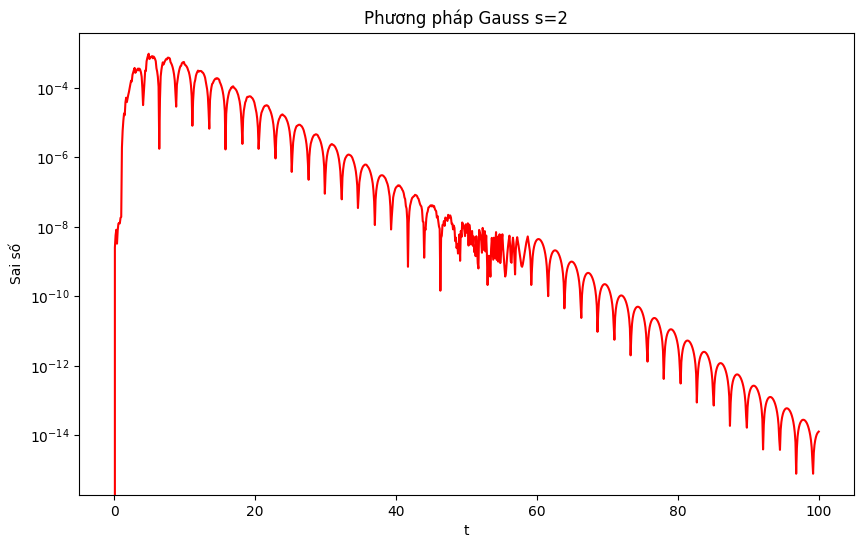

In [19]:
#vẽ đồ thị sai số
plt.figure(figsize=(10, 6))
plt.plot(ts, errors_collocation, 'r-', label='Sai số')
plt.xlabel('t')
plt.yscale('log')
plt.ylabel('Sai số')
plt.title("Phương pháp Gauss s=2")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Phương pháp RK4+Hermite')

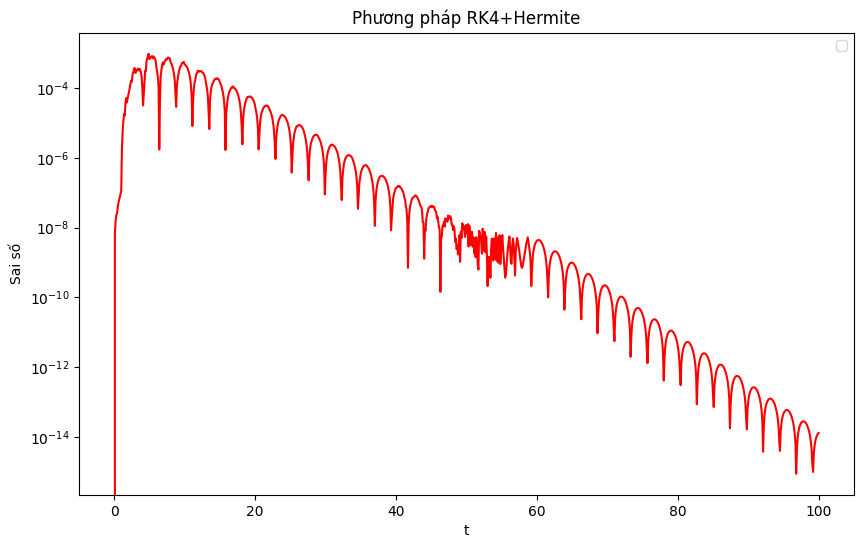

In [22]:
#vẽ đồ thị sai số
plt.figure(figsize=(10, 6))
plt.plot(t_values_01, errors_cubic01, 'r-')
# plt.plot(t_values_005, errors_cubic005, 'b-', label='Sai số h=0.05')
plt.legend()
plt.xlabel('t')
plt.yscale('log')
plt.ylabel('Sai số')
plt.title("Phương pháp RK4+Hermite")

Text(0.5, 1.0, 'Phương pháp EMPM(2,4)')

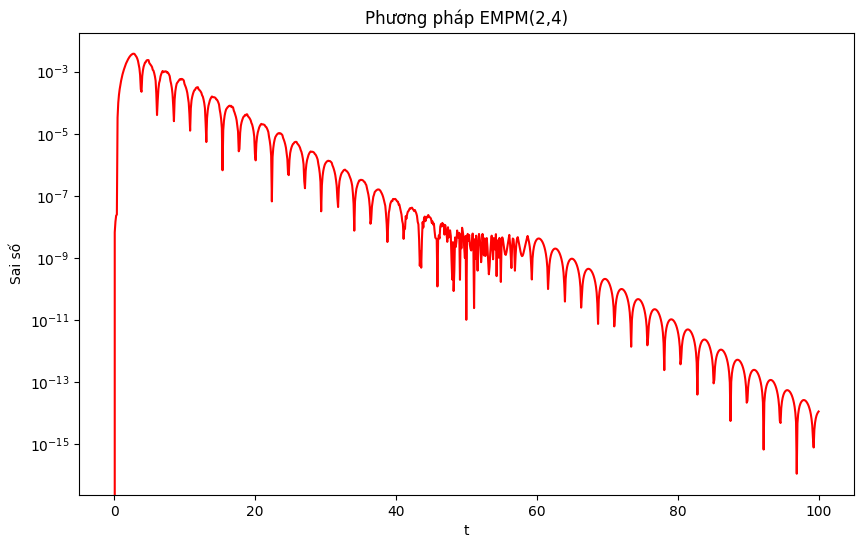

In [21]:
#vẽ đồ thị sai số
plt.figure(figsize=(10, 6))
plt.plot(t_grid, errors_epmm, 'r-', label='Sai số')
plt.xlabel('t')
plt.yscale('log')
plt.ylabel('Sai số')
plt.title("Phương pháp EMPM(2,4)")

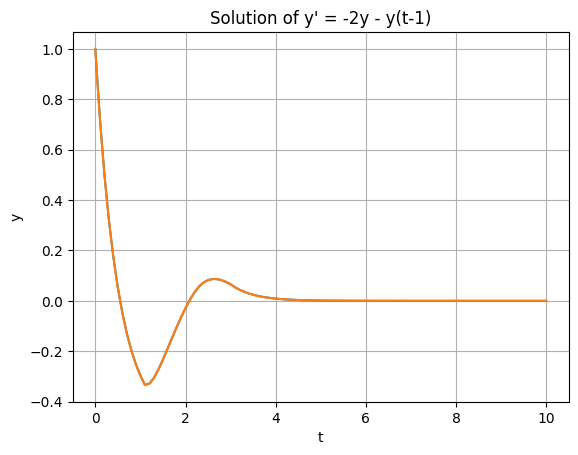

9.999999999999979


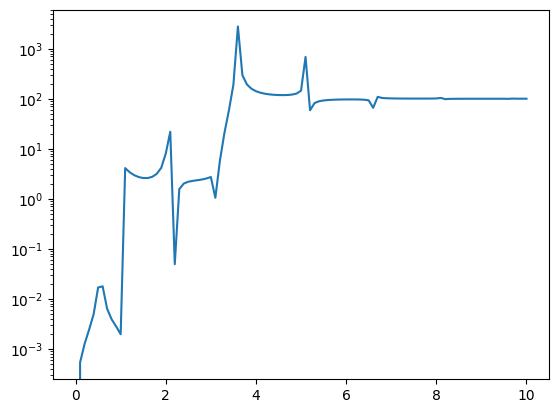

In [6]:
from epmm24_dde_solver import EPMM24Solver
import numpy as np
if __name__ == "__main__":
    f = lambda t, y, ylag: -2.0*y - ylag
    tau = lambda t, y: 1.0
    phi = lambda t, order=0: 1.0 if order == 0 else 0.0

    def y2(t, y, y1, acc):
        return -2.0*y1 - acc.get(1, t, t, y)

    def y3(t, y, y1, y2_, acc):
        return -2.0*y2_ - acc.get(2, t, t, y)

    def y4(t, y, y1, y2_, y3_, acc):
        return -2.0*y3_ - acc.get(3, t, t, y)

    solver = EPMM24Solver(f, tau, phi, y2, y3, y4, (0.0, 10.0), H=0.05)
    ts, ys = solver.integrate()
    # tạo biến ts01 , ys01 từ ts, ys với bước lưới 0.1
    ts01 = np.arange(0, 10.1, 0.1)
    ys01 = np.zeros(len(ts01))
    for i in range(len(ts01)):
        # tìm chỉ số gần nhất trong ts
        index = np.argmin(np.abs(ts - ts01[i]))
        ys01[i] = ys[index]
    # vẽ đồ thị
    plt.plot(ts01, ys01, label='EPMM(2,4)')


    # Lưu kết quả vào file
    with open("epmmsolution.txt", "w") as f:
        for t, y in zip(ts, ys):
            f.write(f"{t} {y}\n")

    try:
        import matplotlib.pyplot as plt
        plt.plot(ts, ys)
        plt.title("Solution of y' = -2y - y(t-1)")
        plt.xlabel("t")
        plt.ylabel("y")
        plt.grid()
        plt.show()
    except Exception:
        print("Matplotlib not available.")
    print(ts[-1])
    y_exact = np.loadtxt('y_exact01.txt')
    relative_error = np.abs((y_exact - ys01) / y_exact)*100
    plt.plot(ts01, relative_error, label="Sai số tuong đối")
    plt.yscale('log')
    

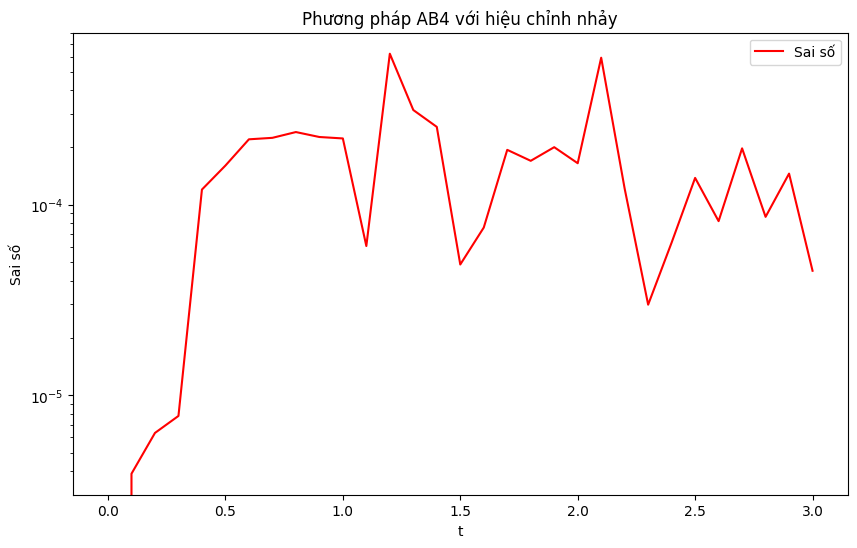

In [80]:
import numpy as np
import math

# === Problem setup ===
def f(t, y, y_delayed):
    return -2 * y - y_delayed

def phi_history(t):
    return 1.0

tau = 1.0  # constant delay

# === Jump-correction polynomial chi and chi_dot ===
def chi(t):
    return 0.0 if t < 1.0 else (1.5 * (t - 1.0)**2 - 2.0 * (t - 1.0)**3)

def chi_dot(t):
    return 0.0 if t < 1.0 else (3.0 * (t - 1.0) - 6.0 * (t - 1.0)**2)

# === Solver parameters ===
T = 3.0
N = 31
h = T / (N - 1)
t_grid = np.linspace(0.0, T, N)

# === Hermite cubic interpolator ===
def interp_delay(y_vals, f_vals, t_vals, tq):
    if tq <= 0:
        return phi_history(tq)
    j = min(int((tq) // h), len(t_vals) - 2)
    r = (tq - t_vals[j]) / h
    h00 = 1 - 3*r**2 + 2*r**3
    h10 = r - 2*r**2 + r**3
    h01 = 3*r**2 - 2*r**3
    h11 = -r**2 + r**3
    return (h00 * y_vals[j] + h*h10 * f_vals[j] +
            h01 * y_vals[j+1] + h*h11 * f_vals[j+1])

# === Prepare arrays ===
y_corr = np.zeros(N)
y_full = np.zeros(N)
f_corr = np.zeros(N)
f_full = np.zeros(N)

# initial
y_full[0] = phi_history(0.0)
y_corr[0] = y_full[0] - chi(0.0)
# full RHS at t0 uses history
f_full[0] = f(0.0, y_full[0], phi_history(-tau))
f_corr[0] = f_full[0] - chi_dot(0.0)

# === Startup with RK4 on corrected system ===
for i in range(0, 3):
    ti = t_grid[i]
    def rhs_corr(tt, yc):
        y_f = yc + chi(tt)
        ydel_f = interp_delay(y_full, f_full, t_grid, tt - tau)
        return f(tt, y_f, ydel_f) - chi_dot(tt)
    k1 = rhs_corr(ti, y_corr[i])
    k2 = rhs_corr(ti + h/2, y_corr[i] + 0.5*h*k1)
    k3 = rhs_corr(ti + h/2, y_corr[i] + 0.5*h*k2)
    k4 = rhs_corr(ti + h, y_corr[i] + h*k3)
    y_corr[i+1] = y_corr[i] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
    # reconstruct full and compute RHS
    y_full[i+1] = y_corr[i+1] + chi(t_grid[i+1])
    ydel = interp_delay(y_full, f_full, t_grid, t_grid[i+1] - tau)
    f_full[i+1] = f(t_grid[i+1], y_full[i+1], ydel)
    f_corr[i+1] = f_full[i+1] - chi_dot(t_grid[i+1])

# === Main loop: AB4 on y_corr ===
for i in range(3, N-1):
    # update full and corr RHS at i
    y_full[i] = y_corr[i] + chi(t_grid[i])
    ydel = interp_delay(y_full, f_full, t_grid, t_grid[i] - tau)
    f_full[i] = f(t_grid[i], y_full[i], ydel)
    f_corr[i] = f_full[i] - chi_dot(t_grid[i])
    # AB4 step on corrected
    y_corr[i+1] = (y_corr[i] +
                   (h/24) * (55*f_corr[i] - 59*f_corr[i-1]
                             + 37*f_corr[i-2] - 9*f_corr[i-3]))
    # reconstruct full and compute new full & corr RHS
    y_full[i+1] = y_corr[i+1] + chi(t_grid[i+1])
    ydel1 = interp_delay(y_full, f_full, t_grid, t_grid[i+1] - tau)
    f_full[i+1] = f(t_grid[i+1], y_full[i+1], ydel1)
    f_corr[i+1] = f_full[i+1] - chi_dot(t_grid[i+1])

# Compute final solution
y = y_full.copy()

# === Compute error ===
def y_exact(t):
    if t <= 0:
        return 1.0
    n = int(math.floor(t))
    s = 0.0
    for k in range(n + 1):
        u = t - k
        sum_m = sum((2*u)**m / math.factorial(m) for m in range(k + 1))
        s += ((1 - math.exp(-2*u) * sum_m) / (2**(k + 1))) * ((-1)**k)
    return 1 - 3 * s

errors = np.abs(y - np.array([y_exact(tt) for tt in t_grid]))
from matplotlib import pyplot as plt
# vẽ đồ thị sai số
plt.figure(figsize=(10, 6))
plt.plot(t_grid, errors, 'r-', label='Sai số')
plt.xlabel('t')
plt.yscale('log')
plt.ylabel('Sai số')
plt.title("Phương pháp AB4 với hiệu chỉnh nhảy")
plt.legend()
plt.show()


In [55]:
import numpy as np

# Giả sử h_list và MaxEror_list là các mảng numpy
h_list = np.array([0.1, 0.05, 0.025, 0.0125])
MaxErorr_list = np.array([0.0006992746372845859, 0.00012833438426412824, 1.9405725361576476e-05, 2.6664704901868674e-06])

# Cách 1: tính p cho từng cặp lân cận, rồi lấy trung bình
p_pairs = np.log(MaxErorr_list[:-1] / MaxErorr_list[1:]) / np.log(h_list[:-1] / h_list[1:])
p_est1 = np.mean(p_pairs)

# Cách 2: hồi quy tuyến tính trên log–log
x = np.log(h_list)
y = np.log(MaxErorr_list)
A = np.vstack([x, np.ones_like(x)]).T
p_est2, logC = np.linalg.lstsq(A, y, rcond=None)[0]

print("p (cặp lân cận):", p_pairs, "=> trung bình =", p_est1)
print("p (hồi quy):", p_est2)


p (cặp lân cận): [2.44595142 2.72535349 2.86347909] => trung bình = 2.678261335833499
p (hồi quy): 2.6829705516504108


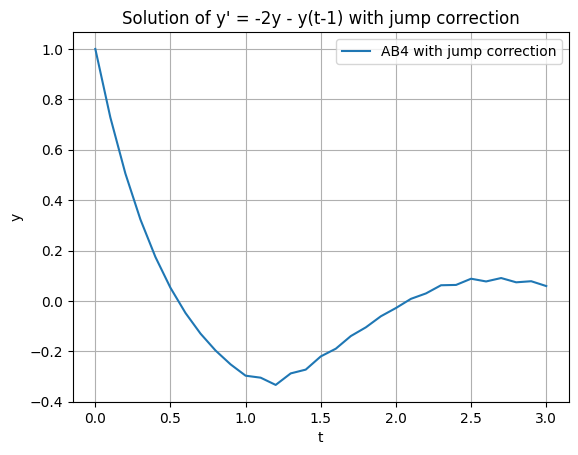

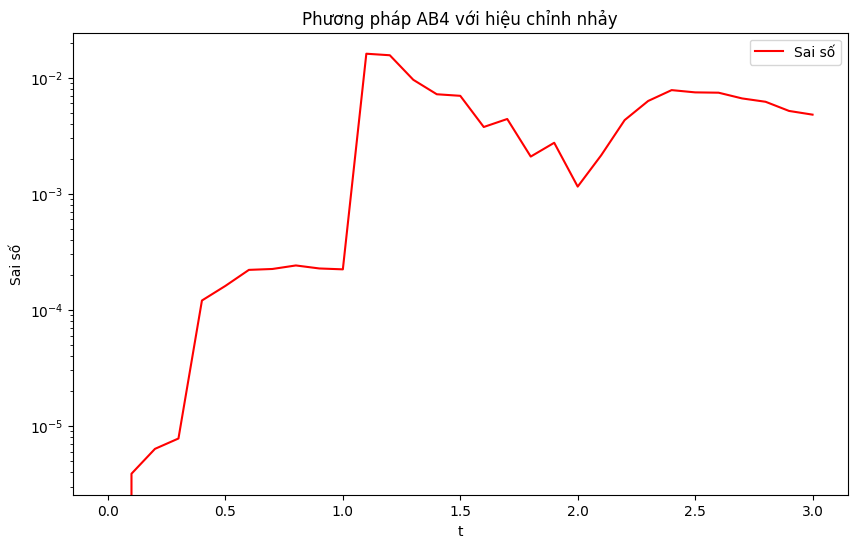

In [81]:
import numpy as np
import sympy as sp
from sympy import Function, diff, Piecewise

def build_chi(f_sym, phi_sym, tau, t, y):
    """
    Build jump-correction chi and derivative chi_dot for DDE solver.
    """
    phi_sym = sp.sympify(phi_sym)
    s = sp.symbols('s')
    
    # partials
    f_t  = diff(f_sym, t)
    f_y  = diff(f_sym, y(t))
    f_yd = diff(f_sym, y(t - tau))
    
    # compute y'(tau^-) and y'(tau^+)
    y_delay_val_pre  = phi_sym.subs(t, 0)
    y_val_pre        = phi_sym.subs(t, tau)
    yprime_tau_minus = sp.N(f_sym.subs({
        t: tau,
        y(t):       y_val_pre,
        y(t - tau): y_delay_val_pre
    }))
    # assume continuity of y' at tau
    yprime_tau_plus = yprime_tau_minus
    
    # history derivative at 0 for y(t - tau)
    if phi_sym.free_symbols:
        phi_dot0 = diff(phi_sym, t).subs(t, 0)
    else:
        phi_dot0 = 0
    
    # substitutions
    subs_pre = {
        t:            tau,
        y(t):         y_val_pre,
        y(t - tau):   y_delay_val_pre,
        diff(y(t), t):      yprime_tau_minus,
        diff(y(t - tau), t): phi_dot0
    }
    subs_post = {
        t:            tau,
        y(t):         y_val_pre,
        y(t - tau):   y_delay_val_pre,
        diff(y(t), t):      yprime_tau_plus,
        diff(y(t - tau), t): yprime_tau_minus
    }
    
    # build y'' and y'''
    y2 = f_t + f_y * f_sym + f_yd * diff(y(t - tau), t)
    y3 = diff(y2, t)
    
    # compute jumps
    Delta2 = sp.simplify(y2.subs(subs_post) - y2.subs(subs_pre))
    Delta3 = sp.simplify(y3.subs(subs_post) - y3.subs(subs_pre))
    
    # optional jump in y''''
    y4 = diff(y3, t)
    Delta4 = sp.simplify(y4.subs(subs_post) - y4.subs(subs_pre))
    
    # coefficients
    a2 = Delta2/2
    a3 = Delta3/6
    a4 = Delta4/24
    
    chi_s     = a2*s**2 + a3*s**3 + a4*s**4
    chi_dot_s = diff(chi_s, s)
    
    # lambdify
    chi_func     = sp.lambdify(t, Piecewise((0, t<tau), (chi_s.subs(s, t-tau), True)), 'numpy')
    chi_dot_func = sp.lambdify(t, Piecewise((0, t<tau), (chi_dot_s.subs(s, t-tau), True)), 'numpy')
    return chi_func, chi_dot_func

def dde_solver_ab4(f_num, phi_num, tau, T, N, chi, chi_dot):
    h = T/(N-1)
    t_grid = np.linspace(0, T, N)
    y_full = np.zeros(N); y_corr = np.zeros(N)
    f_full = np.zeros(N); f_corr = np.zeros(N)
    
    # initial
    y_full[0] = phi_num(0)
    y_corr[0] = y_full[0] - chi(0)
    f_full[0] = f_num(0, y_full[0], phi_num(-tau))
    f_corr[0] = f_full[0] - chi_dot(0)
    
    # interpolator
    def interp(yv, fv, tq):
        if tq <= 0:
            return phi_num(tq)
        j = min(int(tq//h), len(yv)-2)
        r = (tq - j*h)/h
        h00 = 1-3*r**2+2*r**3; h10 = r-2*r**2+r**3
        h01 = 3*r**2-2*r**3; h11 = -r**2+r**3
        return (h00*yv[j] + h*h10*fv[j] +
                h01*yv[j+1] + h*h11*fv[j+1])
    
    # startup RK4
    for i in range(3):
        ti = t_grid[i]
        def rhs_corr(tt, yc):
            return f_num(tt, yc + chi(tt), interp(y_full, f_full, tt - tau)) - chi_dot(tt)
        k1 = rhs_corr(ti, y_corr[i])
        k2 = rhs_corr(ti+h/2, y_corr[i] + 0.5*h*k1)
        k3 = rhs_corr(ti+h/2, y_corr[i] + 0.5*h*k2)
        k4 = rhs_corr(ti+h,   y_corr[i] +   h*k3)
        y_corr[i+1] = y_corr[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        y_full[i+1] = y_corr[i+1] + chi(t_grid[i+1])
        f_full[i+1] = f_num(t_grid[i+1], y_full[i+1], interp(y_full, f_full, t_grid[i+1]-tau))
        f_corr[i+1] = f_full[i+1] - chi_dot(t_grid[i+1])
    
    # AB4 loop
    for i in range(3, N-1):
        y_full[i]  = y_corr[i] + chi(t_grid[i])
        f_full[i]  = f_num(t_grid[i], y_full[i], interp(y_full, f_full, t_grid[i]-tau))
        f_corr[i]  = f_full[i] - chi_dot(t_grid[i])
        y_corr[i+1] = (y_corr[i] +
                       (h/24)*(55*f_corr[i]
                              -59*f_corr[i-1]
                              +37*f_corr[i-2]
                              -9*f_corr[i-3]))
        y_full[i+1] = y_corr[i+1] + chi(t_grid[i+1])
        f_full[i+1] = f_num(t_grid[i+1], y_full[i+1], interp(y_full, f_full, t_grid[i+1]-tau))
        f_corr[i+1] = f_full[i+1] - chi_dot(t_grid[i+1])
    
    return t_grid, y_full

def main():
    # === USER INPUT ===
    t = sp.symbols('t')
    y = Function('y')
    
    tau_val = 1.0
    T_val   = 3.0
    N_val   = 31
    
    # define symbolically here:
    f_sym   = -2*y(t) - y(t - tau_val)
    phi_sym = 1
    
    chi, chi_dot = build_chi(f_sym, phi_sym, tau_val, t, y)
    f_num   = sp.lambdify((t, y(t), y(t - tau_val)), f_sym, 'numpy')
    phi_num = sp.lambdify(t, phi_sym, 'numpy')
    
    t_grid, y_sol = dde_solver_ab4(f_num, phi_num, tau_val, T_val, N_val, chi, chi_dot)

    from matplotlib import pyplot as plt
    # Plot the solution
    plt.plot(t_grid, y_sol, label='AB4 with jump correction')
    plt.title("Solution of y' = -2y - y(t-1) with jump correction")
    plt.xlabel("t")
    plt.ylabel("y")
    plt.grid()
    plt.legend()
    y_exact_vals = np.array([y_exact(tt) for tt in t_grid])
    errors = np.abs(y_sol - y_exact_vals)
    plt.figure(figsize=(10, 6))
    plt.plot(t_grid, errors, 'r-', label='Sai số')
    plt.xlabel('t')
    plt.yscale('log')
    plt.ylabel('Sai số')
    plt.title("Phương pháp AB4 với hiệu chỉnh nhảy")
    plt.legend()
    plt.show()
def y_exact(t):
    if t <= 0:
        return 1.0
    n = int(math.floor(t))
    s = 0.0
    for k in range(n + 1):
        u = t - k
        sum_m = sum((2*u)**m / math.factorial(m) for m in range(k + 1))
        s += ((1 - math.exp(-2*u) * sum_m) / (2**(k + 1))) * ((-1)**k)
    return 1 - 3 * s

if __name__ == "__main__":
    main()
    


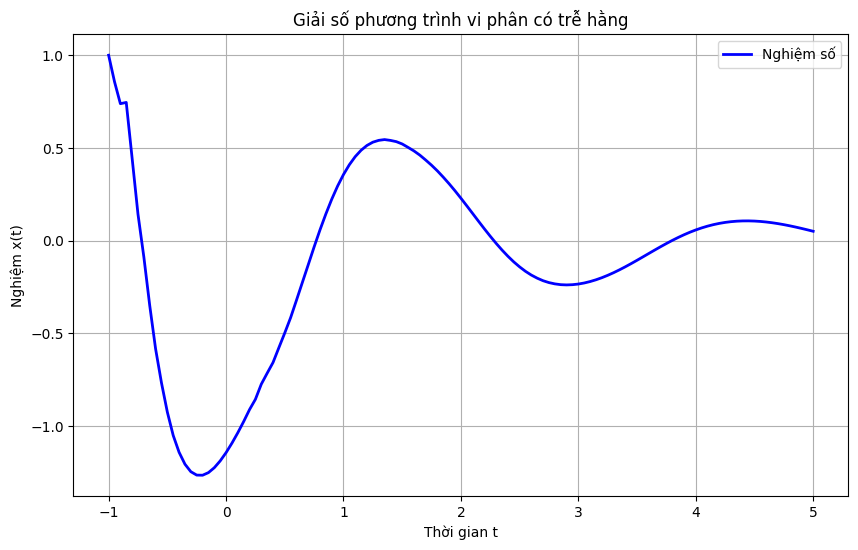

In [62]:
import numpy as np
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt

class DDE_Solver:
    def __init__(self, tau, T, h, history, f, jump_points=None):
        """
        Khởi tạo bộ giải DDE
        tau: Thời gian trễ hằng
        T: Thời gian kết thúc
        h: Bước thời gian
        history: Hàm lịch sử trên [-tau, 0]
        f: Hàm vế phải f(t, x(t), x(t-tau))
        jump_points: Danh sách điểm bước nhảy (mặc định: [k*tau])
        """
        self.tau = tau
        self.T = T
        self.h = h
        self.history = history
        self.f = f
        
        # Lưới thời gian
        self.t = np.arange(-tau, T + h, h)
        self.n = len(self.t)
        self.x = np.zeros(self.n)
        
        # Khởi tạo lịch sử
        for i, t_i in enumerate(self.t):
            if t_i <= 0:
                self.x[i] = history(t_i)
        
        # Điểm bước nhảy (mặc định tại k*tau)
        if jump_points is None:
            self.jump_points = [k * tau for k in range(0, int(T/tau) + 1)]
        else:
            self.jump_points = jump_points
        
        # Hàm hiệu chỉnh bước nhảy χ
        self.chi = self.compute_chi()
        
        # Phương pháp đa bước cơ sở (Adams-Bashforth bậc 4)
        self.alpha = np.array([1, -1, 0, 0, 0])
        self.beta = np.array([55/24, -59/24, 37/24, -9/24])
        
        # Sơ đồ nội suy Lagrange bậc 3
        self.degree = 3
    
    def compute_chi(self):
        """Xây dựng hàm hiệu chỉnh bước nhảy χ (đa thức từng khúc bậc 3)"""
        # Mặc định χ = 0 nếu không có bước nhảy
        chi = np.zeros(self.n)
        return chi
    
    def interpolate(self, t_target):
        """
        Nội suy giá trị tại t_target sử dụng Lagrange bậc 3
        Trả về giá trị nội suy của x(t_target)
        """
        # Tìm 4 điểm lưới gần nhất
        idx = np.searchsorted(self.t, t_target)
        indices = np.clip([idx-2, idx-1, idx, idx+1], 0, self.n-1)
        indices = np.unique(indices)  # Loại bỏ trùng lặp
        
        # Lấy dữ liệu để nội suy
        t_points = self.t[indices]
        x_points = self.x[indices]
        
        # Nội suy Lagrange
        poly = lagrange(t_points, x_points)
        return poly(t_target)
    
    def solve(self):
        """Giải phương trình sử dụng phương pháp đa bước với hiệu chỉnh"""
        # Khởi tạo bằng Runge-Kutta bậc 4 (RK4)
        for i in range(1, 4):
            if i >= self.n:
                break
                
            t_i = self.t[i]
            k1 = self.f(t_i, self.x[i], self.interpolate(t_i - self.tau))
            
            t_mid1 = t_i + 0.5 * self.h
            x_mid1 = self.x[i] + 0.5 * self.h * k1
            k2 = self.f(t_mid1, x_mid1, self.interpolate(t_mid1 - self.tau))
            
            t_mid2 = t_i + 0.5 * self.h
            x_mid2 = self.x[i] + 0.5 * self.h * k2
            k3 = self.f(t_mid2, x_mid2, self.interpolate(t_mid2 - self.tau))
            
            t_end = t_i + self.h
            x_end = self.x[i] + self.h * k3
            k4 = self.f(t_end, x_end, self.interpolate(t_end - self.tau))
            
            self.x[i] += (self.h / 6) * (k1 + 2*k2 + 2*k3 + k4)
        
        # Áp dụng phương pháp đa bước Adams-Bashforth bậc 4
        for i in range(4, self.n):
            t_i = self.t[i]
            
            # Tính giá trị phần trơn z = x - χ
            z_smooth = self.x[i-4:i] - self.chi[i-4:i]
            
            # Tính đạo hàm phần trơn f = z'
            f_smooth = np.zeros(4)
            for j in range(4):
                t_ij = self.t[i-4+j]
                # Tính giá trị trễ cho phần trơn
                delayed_val = self.interpolate(t_ij - self.tau)
                f_smooth[j] = self.f(t_ij, self.x[i-4+j], delayed_val) - self.chi[i-4+j]
            
            # Công thức Adams-Bashforth
            z_next = z_smooth[-1] + self.h * np.dot(self.beta, f_smooth)
            
            # Cập nhật nghiệm tổng x = z + χ
            self.x[i] = z_next + self.chi[i]
            
            # Tính giá trị trễ tại thời điểm hiện tại
            delayed_val = self.interpolate(t_i - self.tau)
            
            # Kiểm tra và xử lý bước nhảy
            if t_i in self.jump_points:
                self.handle_jump(t_i)
    
    def handle_jump(self, t_jump):
        """Xử lý bước nhảy tại thời điểm t_jump (triển khai khi cần)"""
        # Trong trường hợp đơn giản, không cần xử lý thêm
        # Có thể cập nhật χ tại đây cho các bước tiếp theo
        pass
    
    def plot(self):
        """Vẽ đồ thị nghiệm"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.t, self.x, 'b-', linewidth=2, label='Nghiệm số')
        plt.xlabel('Thời gian t')
        plt.ylabel('Nghiệm x(t)')
        plt.title('Giải số phương trình vi phân có trễ hằng')
        plt.grid(True)
        plt.legend()
        plt.show()

# Ví dụ sử dụng: Giải phương trình x'(t) = -x(t - 1)
def main():
    # Tham số bài toán
    tau = 1.0       # Thời gian trễ
    T = 5.0         # Thời gian kết thúc
    h = 0.05        # Bước thời gian
    
    # Điều kiện lịch sử
    def history(t):
        return 1.0 if t <= 0 else 0.0
    
    # Hàm vế phải
    def f(t, x, x_delayed):
        return -2.0 * x - x_delayed
    
    # Khởi tạo và giải
    solver = DDE_Solver(tau, T, h, history, f)
    solver.solve()
    solver.plot()

if __name__ == "__main__":
    main()